In [1]:
import numpy as np
import pandas as pd
import gensim
from sklearn.manifold import TSNE

In [39]:
# Les produits, départements et allées ("aisles")
product_df = pd.read_csv("./data/products.csv")
aisles_df = pd.read_csv("./data/aisles.csv")
deparments_df = pd.read_csv("./data/departments.csv")
# Fusion des trois tableaux sur les clés primaires
products_df = product_df.merge(deparments_df, on="department_id", how="left")
products_df = products_df.merge(aisles_df, on="aisle_id", how="left")

# Informations sur les commandes ("orders")
dist_store_df = pd.read_csv("./data/orders_distance_stores_softmax.csv")
dist_store_df = dist_store_df.drop("Unnamed: 0", axis=1, errors="ignore")
prod_prior_df = pd.read_csv("./data/order_products__prior_specials.csv")
prod_prior_df = prod_prior_df.drop("Unnamed: 0", axis=1, errors="ignore")
orders_df = prod_prior_df.merge(dist_store_df, on="order_id")

# Construction de tableaux regroupant les produits par commande, magasin et utilisateurs
# Ces tableaux seront utilisés pour trouver des vecteurs permettant d'évaluer la similude entre les utilisateurs et magasins
order_products_df = orders_df.groupby("order_id").apply(lambda x: x["product_id"].tolist())
store_products_df = orders_df.groupby("product_id").apply(lambda x: x["store_id"].tolist()).apply(set).apply(list)
user_products_df = orders_df.groupby("product_id").apply(lambda x: x["user_id"].tolist()).apply(set).apply(list)

# Conversion des identifiants uniques en chaîne de caractères afin que ces attribut soit traité comme des attributs catégoriques
for col in ["product_id", "store_id", "user_id", "order_id"]:
    orders_df[col] = orders_df[col].astype(str)

longest = np.max(order_products_df.apply(len))
print("Taille de la commande avec le plus de produits: %d" % longest)

Taille de la commande avec le plus de produits: 98


In [2]:
products_df = pd.read_csv("./data/products.csv")
departments_df = pd.read_csv("./data/departments.csv")
products_df = pd.merge(products_df, departments_df, on="department_id", how="left")
orders_df = pd.read_csv("./data/order_products__prior_specials.csv") # pd.read_csv("./data/train_orders.csv") #p
orders_df.drop("Unnamed: 0", axis=1, errors="ignore")
# Conversion de l'identifiant unique des produits en chaîne de caractères afin que cet attribut soit traité comme un attribut catégorique
orders_df["product_id"] = orders_df["product_id"].astype(str)
# Reconstruction des commandes avec tous les produits
full_orders_df = orders_df.groupby("order_id").apply(lambda x: x["product_id"].tolist())
# On garde de côté la taille de la plus grande commande.
# Cette variable sera utilisée pour définir la taille de la fenêtre du modèle Word2Vec.
longest = np.max(full_orders_df.apply(len))
print("Taille de la commande avec le plus de produits: %d" % longest)

Taille de la commande avec le plus de produits: 98


In [209]:
prod_map = {row.product_id: row.product_name for row in products_df.itertuples()}
dep_map = {row.product_id: row.department for row in products_df.itertuples()}
dep_id_map = {row.department: row.department_id for row in products_df.itertuples()}

In [58]:
(store_products_df.apply(len) < 5).sum() / len(store_products_df)

0.5074014481094127

In [68]:
# Les paramètres du modèle Word2Vec
window_size = longest
n_epochs = 5
embedding_size = 10
min_count = 50  # Drop infrequent items in dataset
number_of_negative_samples = 7
ns_exponent = 0

# Entraînement du modèle
product_model = gensim.models.Word2Vec(
    sentences=full_orders_df,
    sg=1, #  1 for skip-gram
    vector_size=embedding_size,
    window=window_size,
    min_count=min_count,
    workers=4,
    hs=0, # negative sampling will be used.
    negative=number_of_negative_samples,
    ns_exponent=ns_exponent, # The exponent used to shape the negative sampling distribution.
    epochs=n_epochs
)
product_model.save("./models/products.model")

In [67]:
# Les paramètres du modèle Word2Vec
window_size = np.max(store_products_df.apply(len))
n_epochs = 5
embedding_size = 10
min_count = int(store_products_df.apply(len).mean())  # Drop infrequent items in dataset
number_of_negative_samples = 7
ns_exponent = 0

# Entraînement du modèle
store_model = gensim.models.Word2Vec(
    sentences=store_products_df,
    sg=1, #  1 for skip-gram
    vector_size=embedding_size,
    window=window_size,
    min_count=min_count,
    workers=4,
    hs=0, # negative sampling will be used.
    negative=number_of_negative_samples,
    ns_exponent=ns_exponent, # The exponent used to shape the negative sampling distribution.
    epochs=n_epochs
)
store_model.save("./models/store_products.model")

In [66]:
# Les paramètres du modèle Word2Vec
window_size = np.max(user_products_df.apply(len))
n_epochs = 5
embedding_size = 10
min_count = int(user_products_df.apply(len).mean())  # Drop infrequent items in dataset
number_of_negative_samples = 7
ns_exponent = 0

# Entraînement du modèle
user_model = gensim.models.Word2Vec(
    sentences=user_products_df,
    sg=1, #  1 for skip-gram
    vector_size=embedding_size,
    window=window_size,
    min_count=min_count,
    workers=4,
    hs=0, # negative sampling will be used.
    negative=number_of_negative_samples,
    ns_exponent=ns_exponent, # The exponent used to shape the negative sampling distribution.
    epochs=n_epochs
)
store_model.save("./models/user_products.model")

In [228]:
X = product_model.wv.get_normed_vectors()
d = [dep_id_map[dep_map[int(product_model.wv.index_to_key[i])]] for i, _ in enumerate(X)]

X_embed = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(X)
X_embed = np.concatenate(
    (X_embed, np.expand_dims(d, 1)),
    axis=1
)

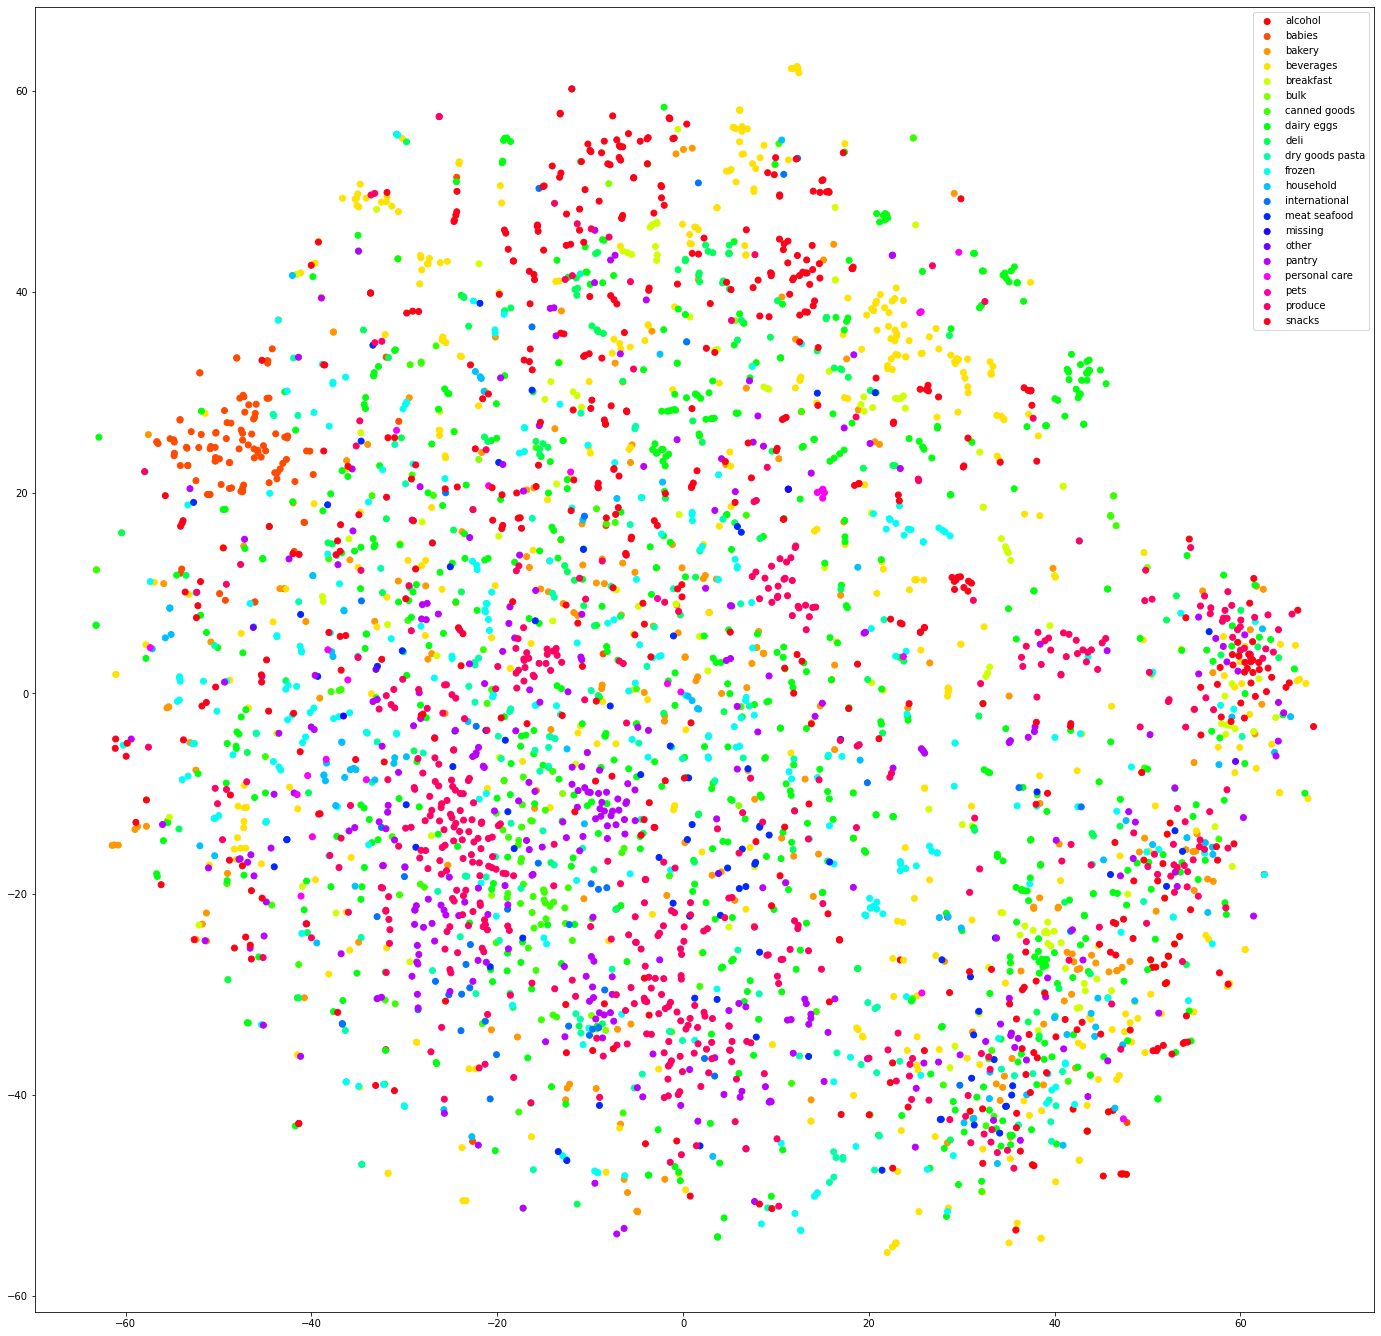

In [229]:
import matplotlib.pyplot as plt

color_map = {k: i for i, k in enumerate(products_df["department"].sort_values().unique())}
n_departments = len(color_map)
palette = plt.cm.get_cmap("hsv", n_departments)

f, ax = plt.subplots(figsize=(24, 24))

for department in color_map.keys():
    dep_id = dep_id_map[department]
    X = X_embed[X_embed[:, 2] == dep_id]
    color_idx = [color_map[department] for _ in range(len(X))]
    ax.scatter(x=X[:, 0], y=X[:, 1], label=department, c=palette(color_idx))
ax.legend()